In [47]:
# import necessary libraries
import os, glob, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import multiprocessing as mp

from tqdm.auto import tqdm
from ipywidgets import FloatProgress
from scipy import ndimage
from PIL import Image
from importlib import reload
from functools import partial

# append path
sys.path.append('../')

# custom
from utils.Metrics import iou
from utils.GetFileNames import get_file_names
import utils.SegmentImage as SegmentImage
import utils.Measure as Measure
import utils.Preprocessing as Preprocessing
import utils.Traits as Traits

In [48]:
# directories
seg_path = '../data/pop_scale/pop_scale_segmentations/'
in_path = '../data/test/test_images/'
postproc_path = '../data/pop_scale/pop_scale_segmentations_postproc/'
out_path = '../data/pop_scale/pop_scale_segmentations_by_pod/'
save_path = '../data/pop_scale/pop_scale_segmentations_measurements/'

# get file names
seg_names = get_file_names(seg_path, '.png')

In [49]:
def postprocess_multi(seg_img, out_path):
    # get image
    seg = np.array(Image.open('../data/pop_scale/pop_scale_segmentations/' + seg_img)) / 255

    # remove artifacts
    post_seg = Preprocessing.remove_artifacts(seg)

    # convert to 
    post_seg = Image.fromarray((post_seg * 255).astype(np.uint8))
    post_seg.save(postproc_path + seg_img)

In [50]:
with mp.Pool(mp.cpu_count()) as pool:
        r = tqdm(pool.imap(partial(postprocess_multi, out_path=out_path), seg_names),
                total = len(seg_names))
        for _ in r:
                pass
print("Postprocessing complete.")

  0%|          | 0/767 [00:00<?, ?it/s]

Postprocessing complete.


In [51]:
# create list to store seed counts and area
measurements = []
reload(Measure)
print("Measuring pods...")
with mp.Pool(mp.cpu_count()) as pool:
        result = tqdm(pool.imap(partial(Measure.measure_pods, 
                                   pred_path=postproc_path,
                                   input_path=in_path,
                                   pod_save_path=out_path),
                                   seg_names),
                total = len(seg_names))
        for r in result:
                measurements.extend(r)
                pass
print("Measurements complete.")

Measuring pods...


  0%|          | 0/767 [00:00<?, ?it/s]

Measurements complete.


In [91]:
# save seed counts to csv
print("Number of Pods Measured:", len(measurements))
measurements = pd.DataFrame(measurements, columns=['image_name', 
                                                    'seed_count',

                                                    # areas
                                                    'wing_area',
                                                    'env_area',
                                                    'seed_area',

                                                    # perimeters
                                                    'wing_perimeter',
                                                    'env_perimeter',
                                                    'seed_perimeter',

                                                    # ...-to-total_area ratios
                                                    'wing_to_total_area',
                                                    'env_to_total_area',
                                                    'seed_to_total_area',

                                                    # ...-to-total_perimeter ratios
                                                    'wing_to_total_perimeter',
                                                    'env_to_total_perimeter',
                                                    'seed_to_total_perimeter',

                                                    # ...-to-seed ratios
                                                    'env_to_seed_area',
                                                    'wing_to_seed_area',
                                                    'env_to_seed_perimeter',
                                                    'wing_to_seed_perimeter',

                                                    # ...-to-env ratios
                                                    'wing_to_env_area',
                                                    'seed_to_env_area',
                                                    'wing_to_env_perimeter',
                                                    'seed_to_env_perimeter',

                                                    # ...-to-wing ratios
                                                    'seed_to_wing_area',
                                                    'env_to_wing_area',
                                                    'seed_to_wing_perimeter',
                                                    'env_to_wing_perimeter',
                                                            
                                                    # color
                                                    'wing_r',
                                                    'wing_g',
                                                    'wing_b',
                                                    'wing_h',
                                                    'wing_s',
                                                    'wing_v',
                                                    'wing_l',
                                                    'wing_a', 
                                                    'wing_B',

                                                    'env_r',
                                                    'env_g',
                                                    'env_b',
                                                    'env_h',
                                                    'env_s',
                                                    'env_v',
                                                    'env_l',
                                                    'env_a',
                                                    'env_B',

                                                    'seed_r',
                                                    'seed_g',
                                                    'seed_b',
                                                    'seed_h',
                                                    'seed_s',
                                                    'seed_v',
                                                    'seed_l',
                                                    'seed_a',
                                                    'seed_B'])

# remove any rows with 0 values
measurements = measurements[measurements != 0]   

# remove any rows with NaN values
measurements = measurements.dropna()

measurements.to_csv(save_path + "measurements.csv", index=False)

Number of Pods Measured: 11309


In [92]:
# EDA
measurements.head()

,image_name,seed_count,wing_area,env_area,seed_area,wing_perimeter,env_perimeter,seed_perimeter,wing_to_total_area,env_to_total_area,...,env_B,seed_r,seed_g,seed_b,seed_h,seed_s,seed_v,seed_l,seed_a,seed_B
0,pred_1.tt8t x fc6-1.B.WBP-2022.W_0.png,10.0,1.093654,0.330268,0.161344,1123.685425,643.026479,1161.643794,0.689887,0.208336,...,129.462098,36.445407,33.678663,34.873153,112.331334,23.542486,36.819282,34.121071,129.593691,127.578252
1,pred_1.tt8t x fc6-1.B.WBP-2022.W_1.png,8.0,0.964245,0.337849,0.136344,1074.271211,622.884343,919.678282,0.670342,0.234872,...,130.527530,35.791535,33.298239,33.369479,72.296793,24.167192,36.068743,33.487119,129.200841,128.339642
2,pred_1.tt8t x fc6-1.B.WBP-2022.W_2.png,9.0,1.042220,0.320465,0.155053,1095.744299,626.256926,1033.259018,0.686693,0.211147,...,130.071972,36.896209,34.795423,35.691516,94.988904,20.732779,37.416089,35.295192,129.201687,127.665280
3,pred_1.tt8t x fc6-1.B.WBP-2022.W_3.png,10.0,1.082148,0.363458,0.158028,1148.472222,662.683333,1086.229581,0.674810,0.226646,...,128.426014,37.857337,35.582445,37.325130,124.449762,21.882626,38.629168,36.346450,129.463484,127.156725
4,pred_1.tt8t x fc6-1.B.WBP-2022.W_4.png,10.0,1.046019,0.336182,0.162276,1105.383910,648.825469,1132.957503,0.677264,0.217667,...,128.720987,36.846383,33.564329,35.227057,122.581005,26.961900,37.334953,34.189619,129.951850,127.382551


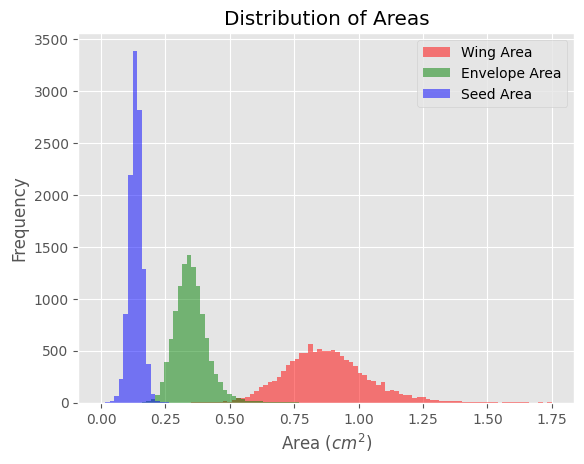

In [93]:
# plot distribution of tissue areas to check for outliers
with plt.style.context('ggplot'):
    plt.hist(measurements["wing_area"], bins=100, range=(0, 1.75), label = "Wing Area", color = "red", alpha = 0.5);
    plt.hist(measurements["env_area"], bins=100, range=(0, 1.75), label = "Envelope Area", color = "green", alpha = 0.5);
    plt.hist(measurements["seed_area"], bins=100, range=(0, 1.75), label = "Seed Area", color = "blue", alpha = 0.5);
    plt.xlabel("Area ($cm^{2}$)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Areas")
    plt.legend()
    plt.show()

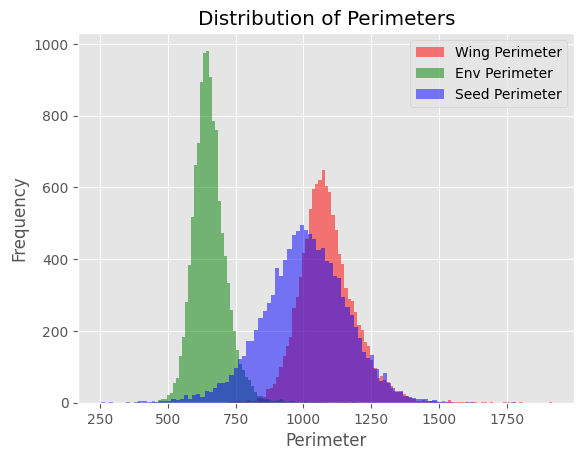

In [94]:
# plot distribution of tissue perims to check for outliers
with plt.style.context('ggplot'):
    plt.hist(measurements["wing_perimeter"], bins=100, label = "Wing Perimeter", color = "red", alpha = 0.5);
    plt.hist(measurements["env_perimeter"], bins=100, label = "Env Perimeter", color = "green", alpha = 0.5);
    plt.hist(measurements["seed_perimeter"], bins=100, label = "Seed Perimeter", color = "blue", alpha = 0.5);
    plt.xlabel("Perimeter")
    plt.ylabel("Frequency")
    plt.title("Distribution of Perimeters")
    plt.legend()
    plt.show()

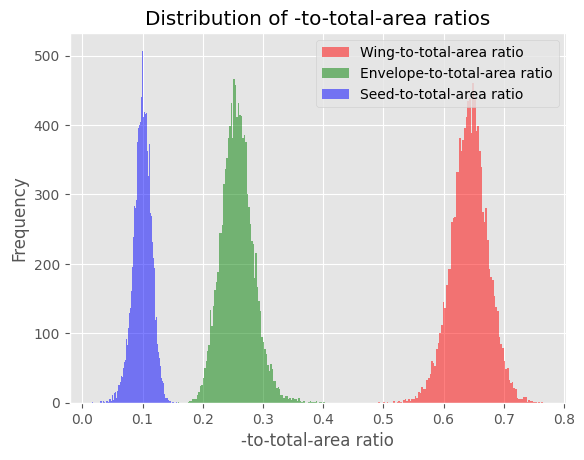

In [95]:
# to-total_area ratios
with plt.style.context('ggplot'):
    plt.hist(measurements["wing_to_total_area"], bins=100, label = "Wing-to-total-area ratio", color = "red", alpha = 0.5);
    plt.hist(measurements["env_to_total_area"], bins=100, label = "Envelope-to-total-area ratio", color = "green", alpha = 0.5);
    plt.hist(measurements["seed_to_total_area"], bins=100, label = "Seed-to-total-area ratio", color = "blue", alpha = 0.5);
    plt.xlabel("-to-total-area ratio")
    plt.ylabel("Frequency")
    plt.title("Distribution of -to-total-area ratios")
    plt.legend()
    plt.show()

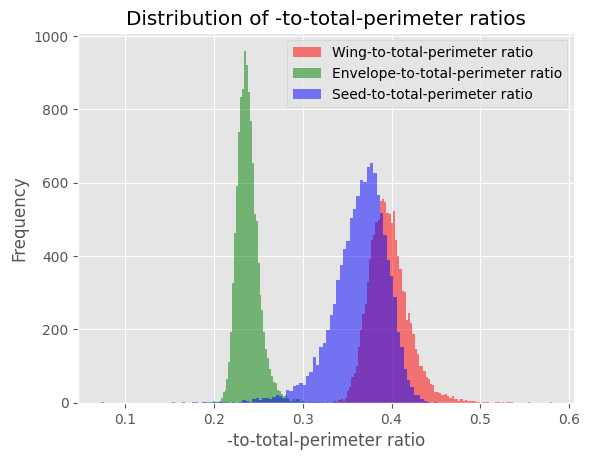

In [96]:
# to-total-perimeter ratios
with plt.style.context('ggplot'):
    plt.hist(measurements["wing_to_total_perimeter"], bins=100, label = "Wing-to-total-perimeter ratio", color = "red", alpha = 0.5);
    plt.hist(measurements["env_to_total_perimeter"], bins=100, label = "Envelope-to-total-perimeter ratio", color = "green", alpha = 0.5);
    plt.hist(measurements["seed_to_total_perimeter"], bins=100, label = "Seed-to-total-perimeter ratio", color = "blue", alpha = 0.5);
    plt.xlabel("-to-total-perimeter ratio")
    plt.ylabel("Frequency")
    plt.title("Distribution of -to-total-perimeter ratios")
    plt.legend()
    plt.show()

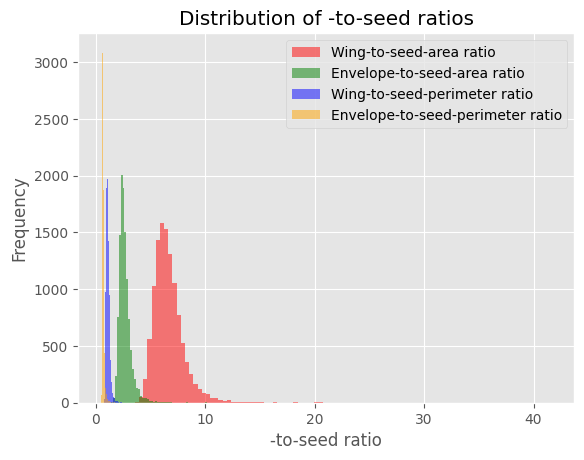

In [97]:
# to-seed ratios
with plt.style.context('ggplot'):
    plt.hist(measurements["wing_to_seed_area"], bins=100, label = "Wing-to-seed-area ratio", color = "red", alpha = 0.5);
    plt.hist(measurements["env_to_seed_area"], bins=100, label = "Envelope-to-seed-area ratio", color = "green", alpha = 0.5);
    plt.hist(measurements["wing_to_seed_perimeter"], bins=100, label = "Wing-to-seed-perimeter ratio", color = "blue", alpha = 0.5);
    plt.hist(measurements["env_to_seed_perimeter"], bins=100, label = "Envelope-to-seed-perimeter ratio", color = "orange", alpha = 0.5);
    plt.xlabel("-to-seed ratio")
    plt.ylabel("Frequency")
    plt.title("Distribution of -to-seed ratios")
    plt.legend()
    plt.show()

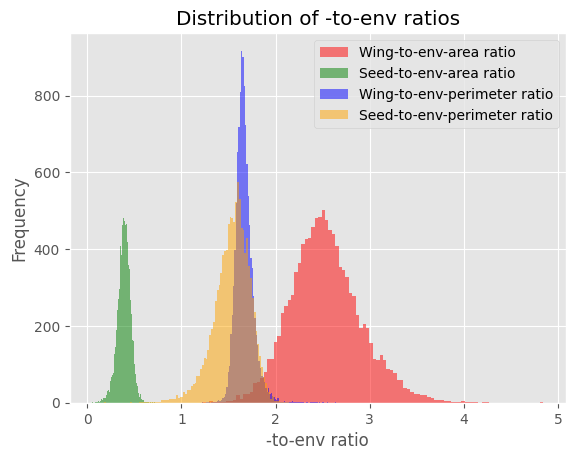

In [98]:
# to-env ratios
with plt.style.context('ggplot'):
    plt.hist(measurements["wing_to_env_area"], bins=100, label = "Wing-to-env-area ratio", color = "red", alpha = 0.5);
    plt.hist(measurements["seed_to_env_area"], bins=100, label = "Seed-to-env-area ratio", color = "green", alpha = 0.5);
    plt.hist(measurements["wing_to_env_perimeter"], bins=100, label = "Wing-to-env-perimeter ratio", color = "blue", alpha = 0.5);
    plt.hist(measurements["seed_to_env_perimeter"], bins=100, label = "Seed-to-env-perimeter ratio", color = "orange", alpha = 0.5);
    plt.xlabel("-to-env ratio")
    plt.ylabel("Frequency")
    plt.title("Distribution of -to-env ratios")
    plt.legend()
    plt.show()

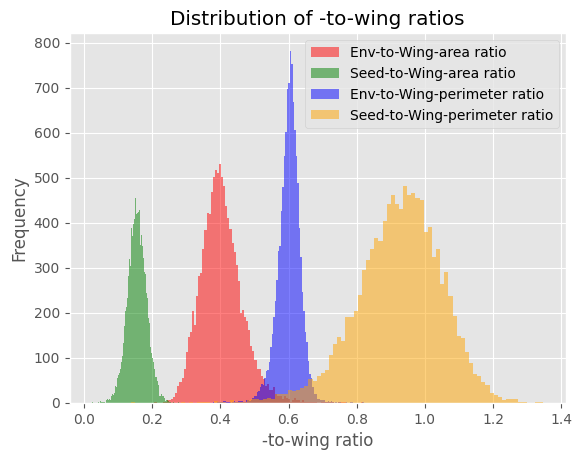

In [99]:
# to-wing ratios
with plt.style.context('ggplot'):
    plt.hist(measurements["env_to_wing_area"], bins=100, label = "Env-to-Wing-area ratio", color = "red", alpha = 0.5);
    plt.hist(measurements["seed_to_wing_area"], bins=100, label = "Seed-to-Wing-area ratio", color = "green", alpha = 0.5);
    plt.hist(measurements["env_to_wing_perimeter"], bins=100, label = "Env-to-Wing-perimeter ratio", color = "blue", alpha = 0.5);
    plt.hist(measurements["seed_to_wing_perimeter"], bins=100, label = "Seed-to-Wing-perimeter ratio", color = "orange", alpha = 0.5);
    plt.xlabel("-to-wing ratio")
    plt.ylabel("Frequency")
    plt.title("Distribution of -to-wing ratios")
    plt.legend()
    plt.show()

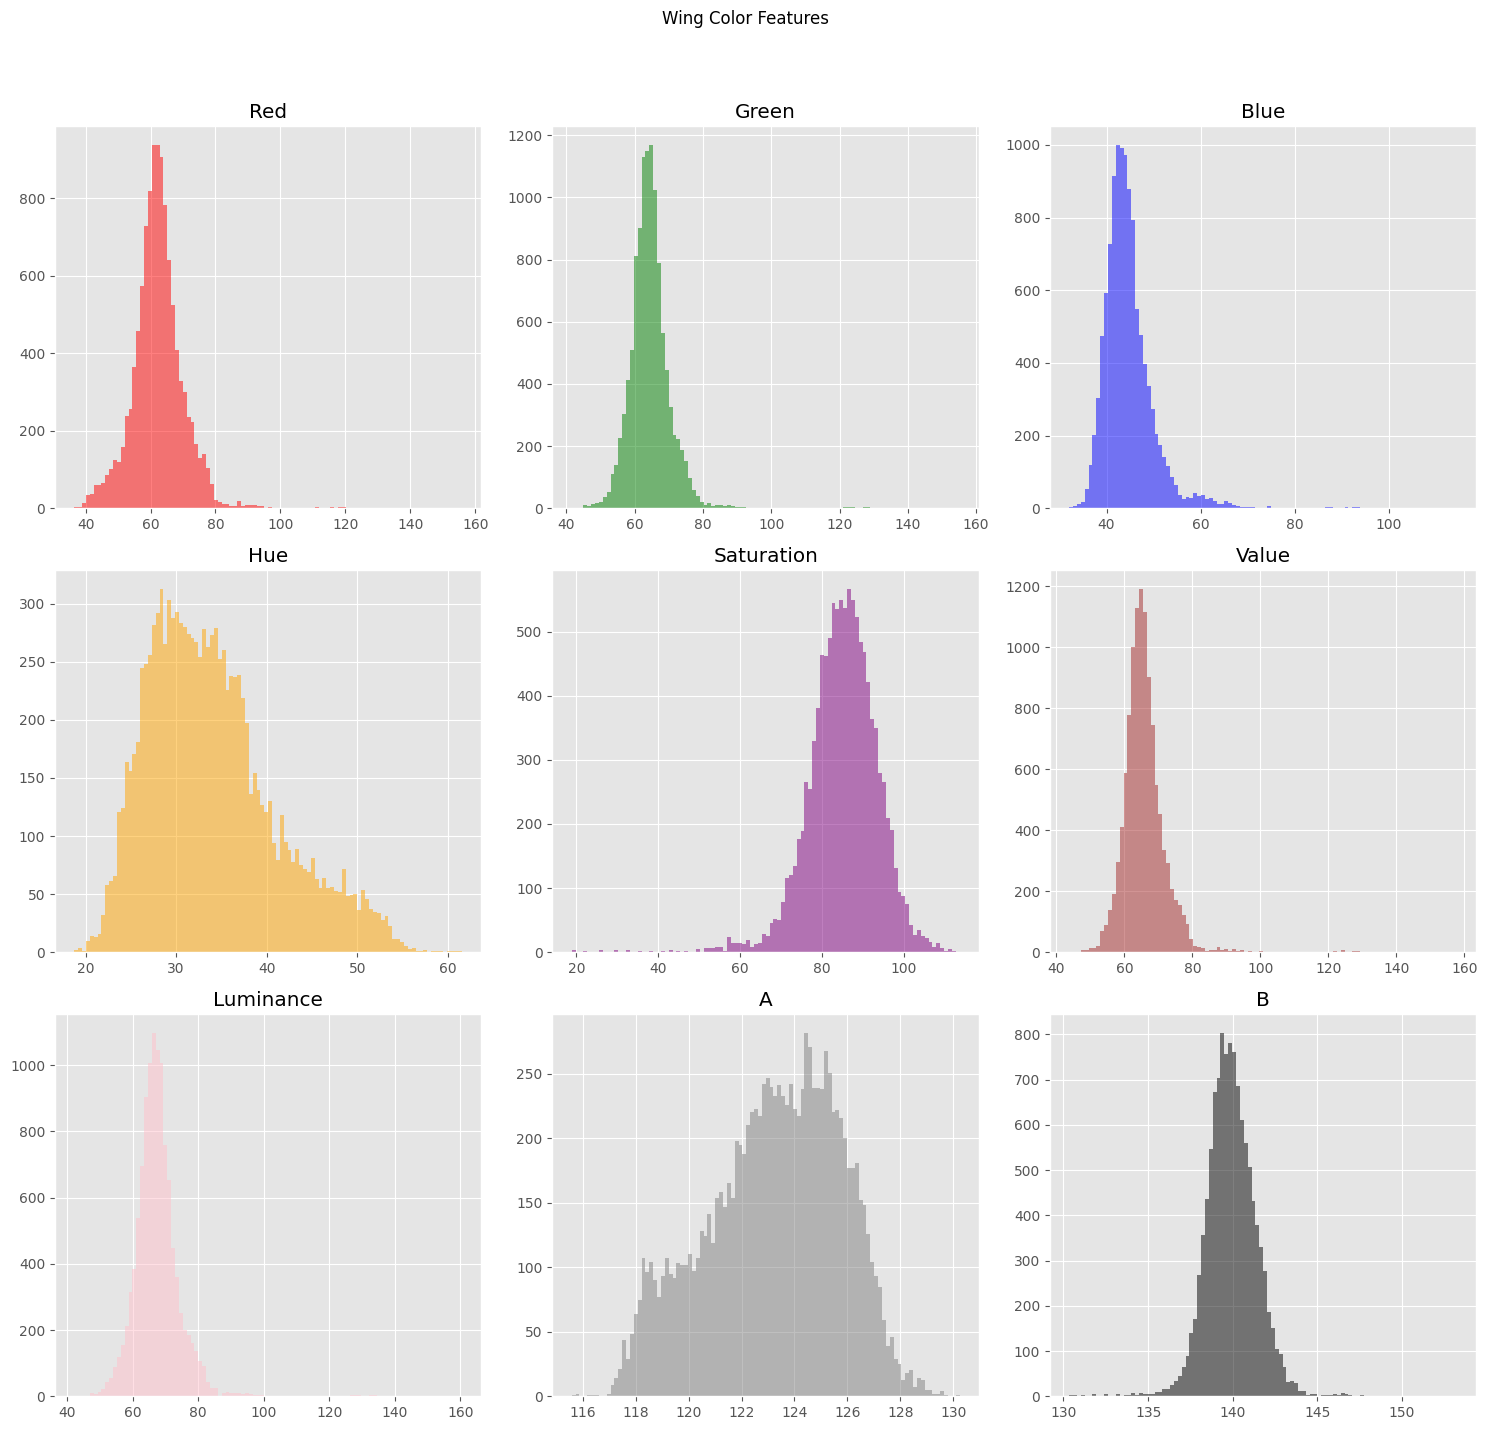

In [100]:
# plot wing color features
with plt.style.context('ggplot'):
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle('Wing Color Features')
    axs[0, 0].hist(measurements["wing_r"], bins=100, label = "Wing Red", color = "red", alpha = 0.5); axs[0, 0].set_title("Red")
    axs[0, 1].hist(measurements["wing_g"], bins=100, label = "Wing Green", color = "green", alpha = 0.5); axs[0, 1].set_title("Green")
    axs[0, 2].hist(measurements["wing_b"], bins=100, label = "Wing Blue", color = "blue", alpha = 0.5); axs[0, 2].set_title("Blue")
    axs[1, 0].hist(measurements["wing_h"], bins=100, label = "Wing Hue", color = "orange", alpha = 0.5); axs[1, 0].set_title("Hue")
    axs[1, 1].hist(measurements["wing_s"], bins=100, label = "Wing Saturation", color = "purple", alpha = 0.5); axs[1, 1].set_title("Saturation")
    axs[1, 2].hist(measurements["wing_v"], bins=100, label = "Wing Value", color = "brown", alpha = 0.5); axs[1, 2].set_title("Value")
    axs[2, 0].hist(measurements["wing_l"], bins=100, label = "Wing Luminance", color = "pink", alpha = 0.5); axs[2, 0].set_title("Luminance")
    axs[2, 1].hist(measurements["wing_a"], bins=100, label = "Wing A", color = "gray", alpha = 0.5); axs[2, 1].set_title("A")
    axs[2, 2].hist(measurements["wing_B"], bins=100, label = "Wing B", color = "black", alpha = 0.5); axs[2, 2].set_title("B")
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

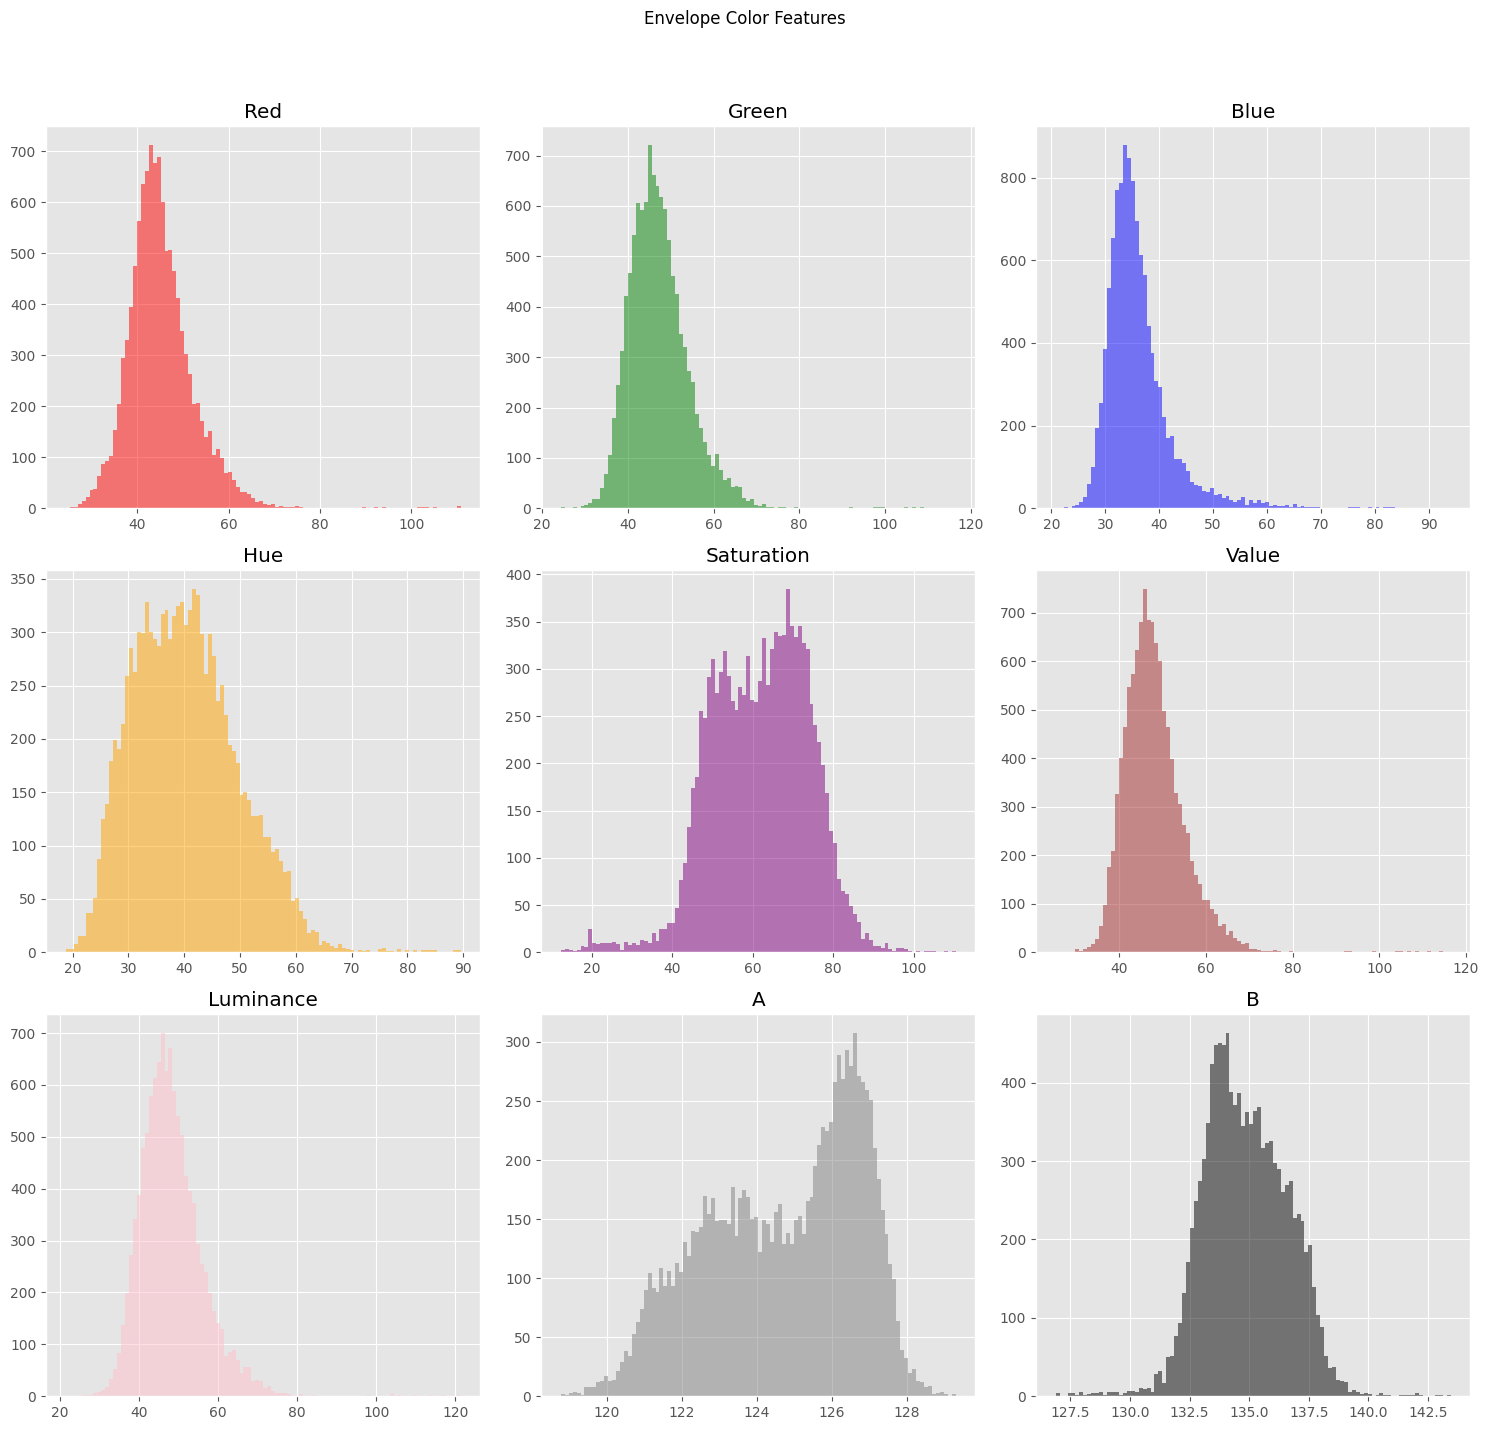

In [101]:
# plot wing color features
with plt.style.context('ggplot'):
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle('Envelope Color Features')
    axs[0, 0].hist(measurements["env_r"], bins=100, label = "Envelope Red", color = "red", alpha = 0.5); axs[0, 0].set_title("Red")
    axs[0, 1].hist(measurements["env_g"], bins=100, label = "Envelope Green", color = "green", alpha = 0.5); axs[0, 1].set_title("Green")
    axs[0, 2].hist(measurements["env_b"], bins=100, label = "Envelope Blue", color = "blue", alpha = 0.5); axs[0, 2].set_title("Blue")
    axs[1, 0].hist(measurements["env_h"], bins=100, label = "Envelope Hue", color = "orange", alpha = 0.5); axs[1, 0].set_title("Hue")
    axs[1, 1].hist(measurements["env_s"], bins=100, label = "Envelope Saturation", color = "purple", alpha = 0.5); axs[1, 1].set_title("Saturation")
    axs[1, 2].hist(measurements["env_v"], bins=100, label = "Envelope Value", color = "brown", alpha = 0.5); axs[1, 2].set_title("Value")
    axs[2, 0].hist(measurements["env_l"], bins=100, label = "Envelope Luminance", color = "pink", alpha = 0.5); axs[2, 0].set_title("Luminance")
    axs[2, 1].hist(measurements["env_a"], bins=100, label = "Envelope A", color = "gray", alpha = 0.5); axs[2, 1].set_title("A")
    axs[2, 2].hist(measurements["env_B"], bins=100, label = "Envelope B", color = "black", alpha = 0.5); axs[2, 2].set_title("B")
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

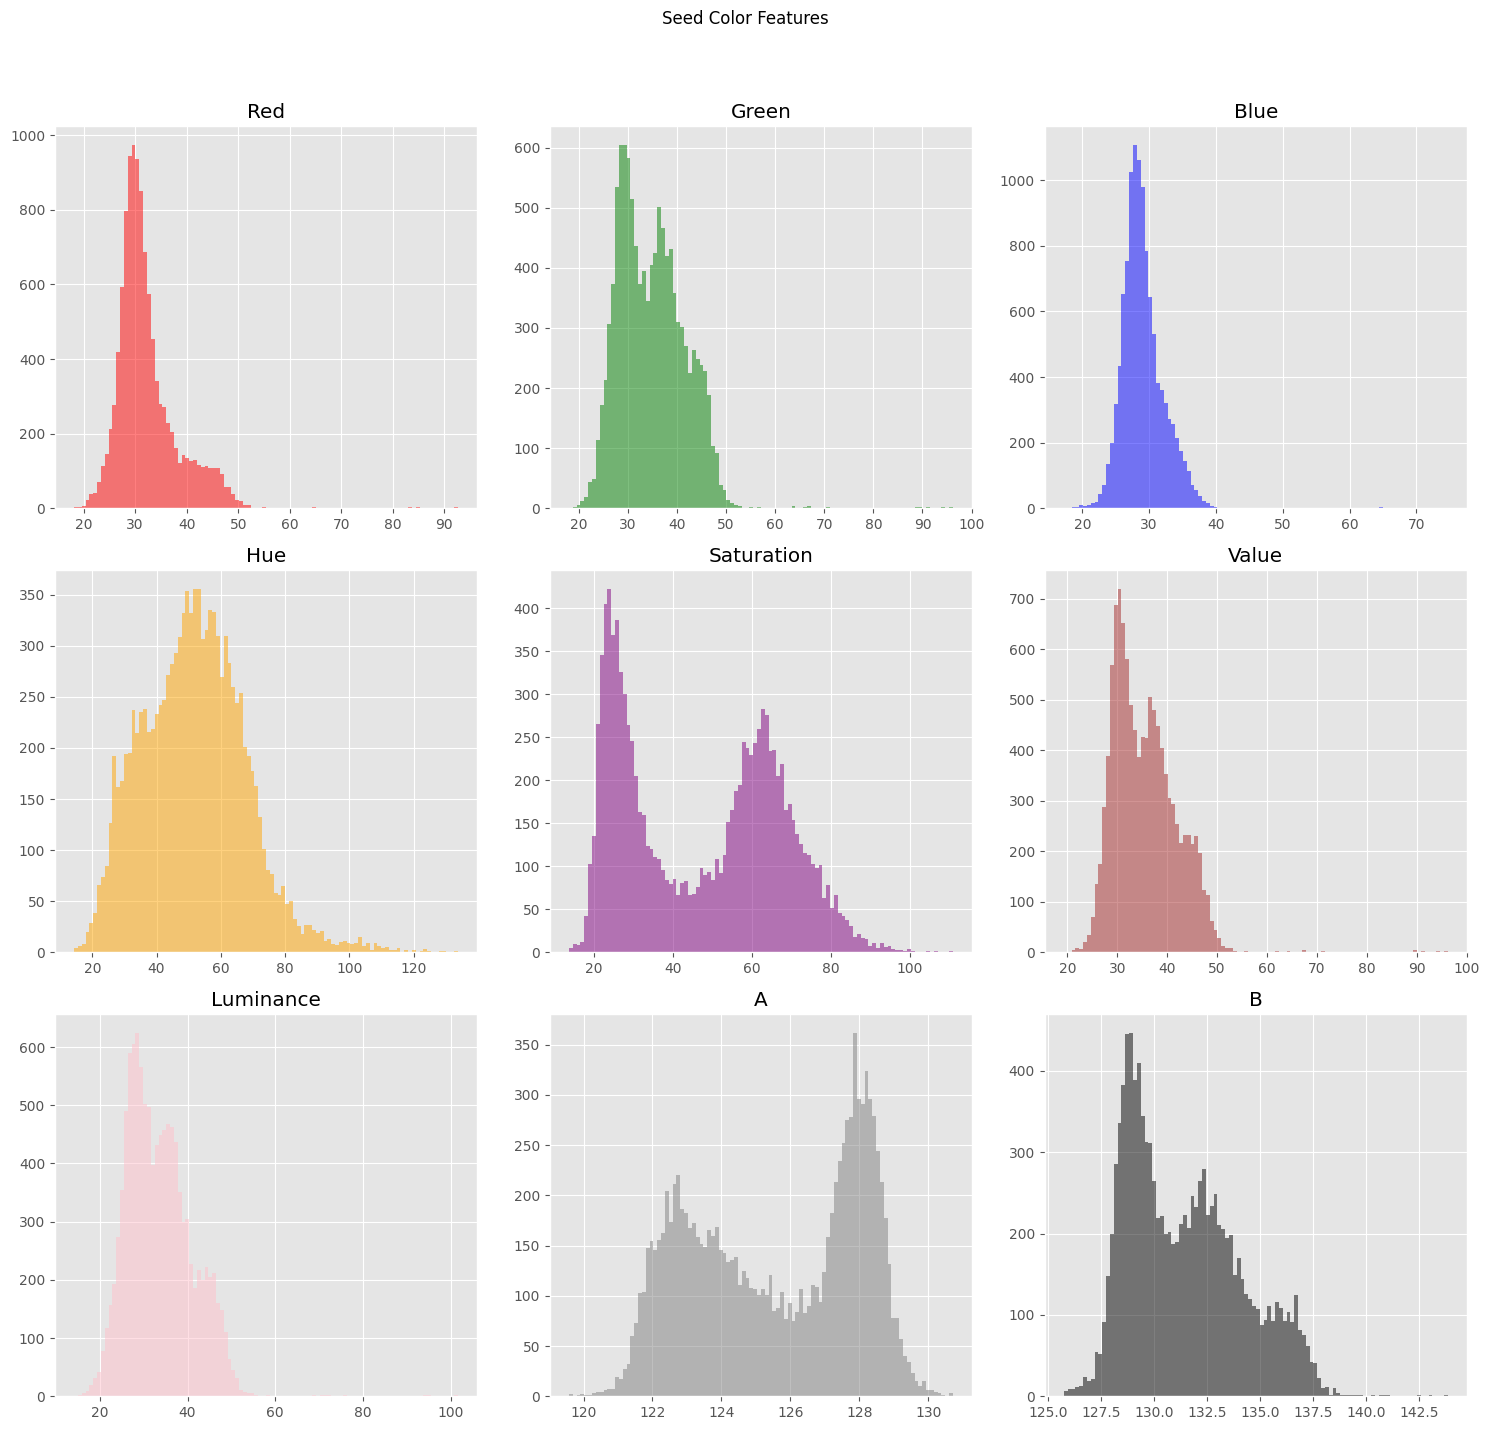

In [102]:
# plot wing color features
with plt.style.context('ggplot'):
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle('Seed Color Features')
    axs[0, 0].hist(measurements["seed_r"], bins=100, label = "Seed Red", color = "red", alpha = 0.5); axs[0, 0].set_title("Red")
    axs[0, 1].hist(measurements["seed_g"], bins=100, label = "Seed Green", color = "green", alpha = 0.5); axs[0, 1].set_title("Green")
    axs[0, 2].hist(measurements["seed_b"], bins=100, label = "Seed Blue", color = "blue", alpha = 0.5); axs[0, 2].set_title("Blue")
    axs[1, 0].hist(measurements["seed_h"], bins=100, label = "Seed Hue", color = "orange", alpha = 0.5); axs[1, 0].set_title("Hue")
    axs[1, 1].hist(measurements["seed_s"], bins=100, label = "Seed Saturation", color = "purple", alpha = 0.5); axs[1, 1].set_title("Saturation")
    axs[1, 2].hist(measurements["seed_v"], bins=100, label = "Seed Value", color = "brown", alpha = 0.5); axs[1, 2].set_title("Value")
    axs[2, 0].hist(measurements["seed_l"], bins=100, label = "Seed Luminance", color = "pink", alpha = 0.5); axs[2, 0].set_title("Luminance")
    axs[2, 1].hist(measurements["seed_a"], bins=100, label = "Seed A", color = "gray", alpha = 0.5); axs[2, 1].set_title("A")
    axs[2, 2].hist(measurements["seed_B"], bins=100, label = "Seed B", color = "black", alpha = 0.5); axs[2, 2].set_title("B")
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

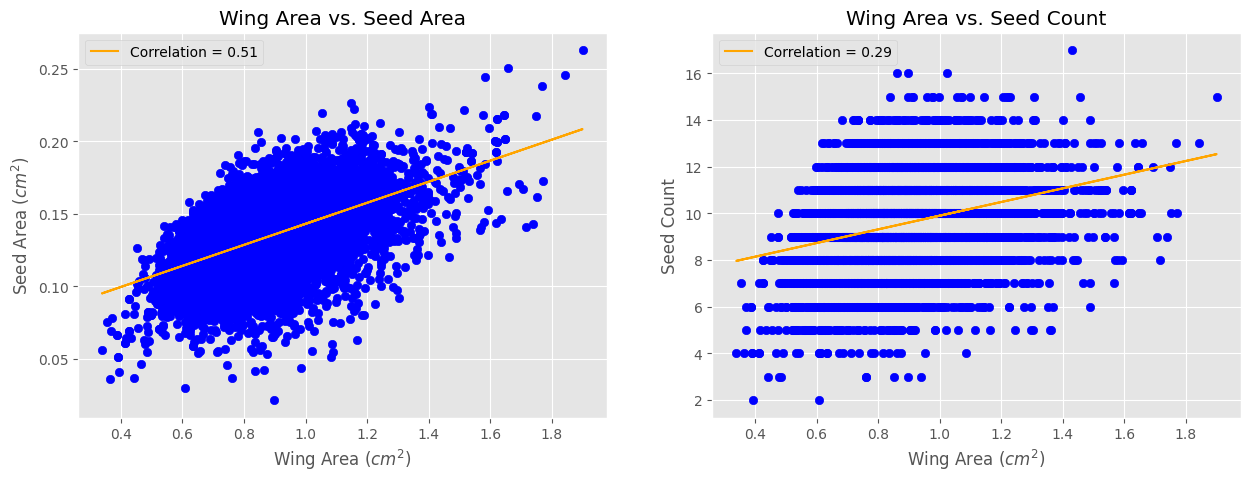

In [103]:
# correlations
# plot correlations for averages
# get lines of best fit for wing area vs. seed area and seed count
area_slope, area_intercept = np.polyfit(measurements["wing_area"], measurements["seed_area"], 1)
count_slope, count_intercept = np.polyfit(measurements["wing_area"], measurements["seed_count"], 1)

area_pearson = np.corrcoef(measurements["wing_area"], measurements["seed_area"])[0, 1]
count_pearson = np.corrcoef(measurements["wing_area"], measurements["seed_count"])[0, 1]

# plot wing area vs. seed area and seed count
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].scatter(measurements["wing_area"], measurements["seed_area"], color = "blue")
    ax[0].plot(measurements["wing_area"], 
               area_slope * measurements["wing_area"] + area_intercept, 
               color = "orange",
               label = f"Correlation = {area_pearson:.2f}")
    ax[0].set_xlabel("Wing Area ($cm^{2}$)")
    ax[0].set_ylabel("Seed Area ($cm^{2}$)")
    ax[0].legend()
    ax[0].set_title("Wing Area vs. Seed Area")

    ax[1].scatter(measurements["wing_area"], measurements["seed_count"], color = "blue")
    ax[1].plot(measurements["wing_area"], 
               count_slope * measurements["wing_area"] + count_intercept, 
               color = "orange",
               label = f"Correlation = {count_pearson:.2f}")
    ax[1].set_xlabel("Wing Area ($cm^{2}$)")
    ax[1].set_ylabel("Seed Count")
    ax[1].legend()
    ax[1].set_title("Wing Area vs. Seed Count")

    plt.show()

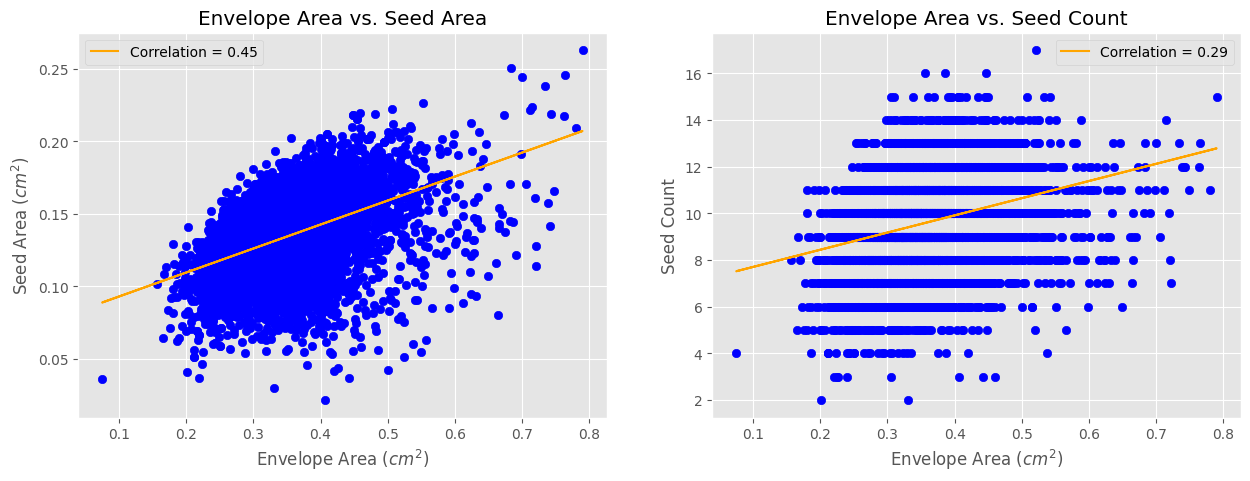

In [104]:
# correlations
# plot correlations for averages
# get lines of best fit for wing area vs. seed area and seed count
area_slope, area_intercept = np.polyfit(measurements["env_area"], measurements["seed_area"], 1)
count_slope, count_intercept = np.polyfit(measurements["env_area"], measurements["seed_count"], 1)

area_pearson = np.corrcoef(measurements["env_area"], measurements["seed_area"])[0, 1]
count_pearson = np.corrcoef(measurements["env_area"], measurements["seed_count"])[0, 1]

# plot wing area vs. seed area and seed count
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].scatter(measurements["env_area"], measurements["seed_area"], color = "blue")
    ax[0].plot(measurements["env_area"], 
               area_slope * measurements["env_area"] + area_intercept, 
               color = "orange",
               label = f"Correlation = {area_pearson:.2f}")
    ax[0].set_xlabel("Envelope Area ($cm^{2}$)")
    ax[0].set_ylabel("Seed Area ($cm^{2}$)")
    ax[0].legend()
    ax[0].set_title("Envelope Area vs. Seed Area")

    ax[1].scatter(measurements["env_area"], measurements["seed_count"], color = "blue")
    ax[1].plot(measurements["env_area"], 
               count_slope * measurements["env_area"] + count_intercept, 
               color = "orange",
               label = f"Correlation = {count_pearson:.2f}")
    ax[1].set_xlabel("Envelope Area ($cm^{2}$)")
    ax[1].set_ylabel("Seed Count")
    ax[1].legend()
    ax[1].set_title("Envelope Area vs. Seed Count")

    plt.show()

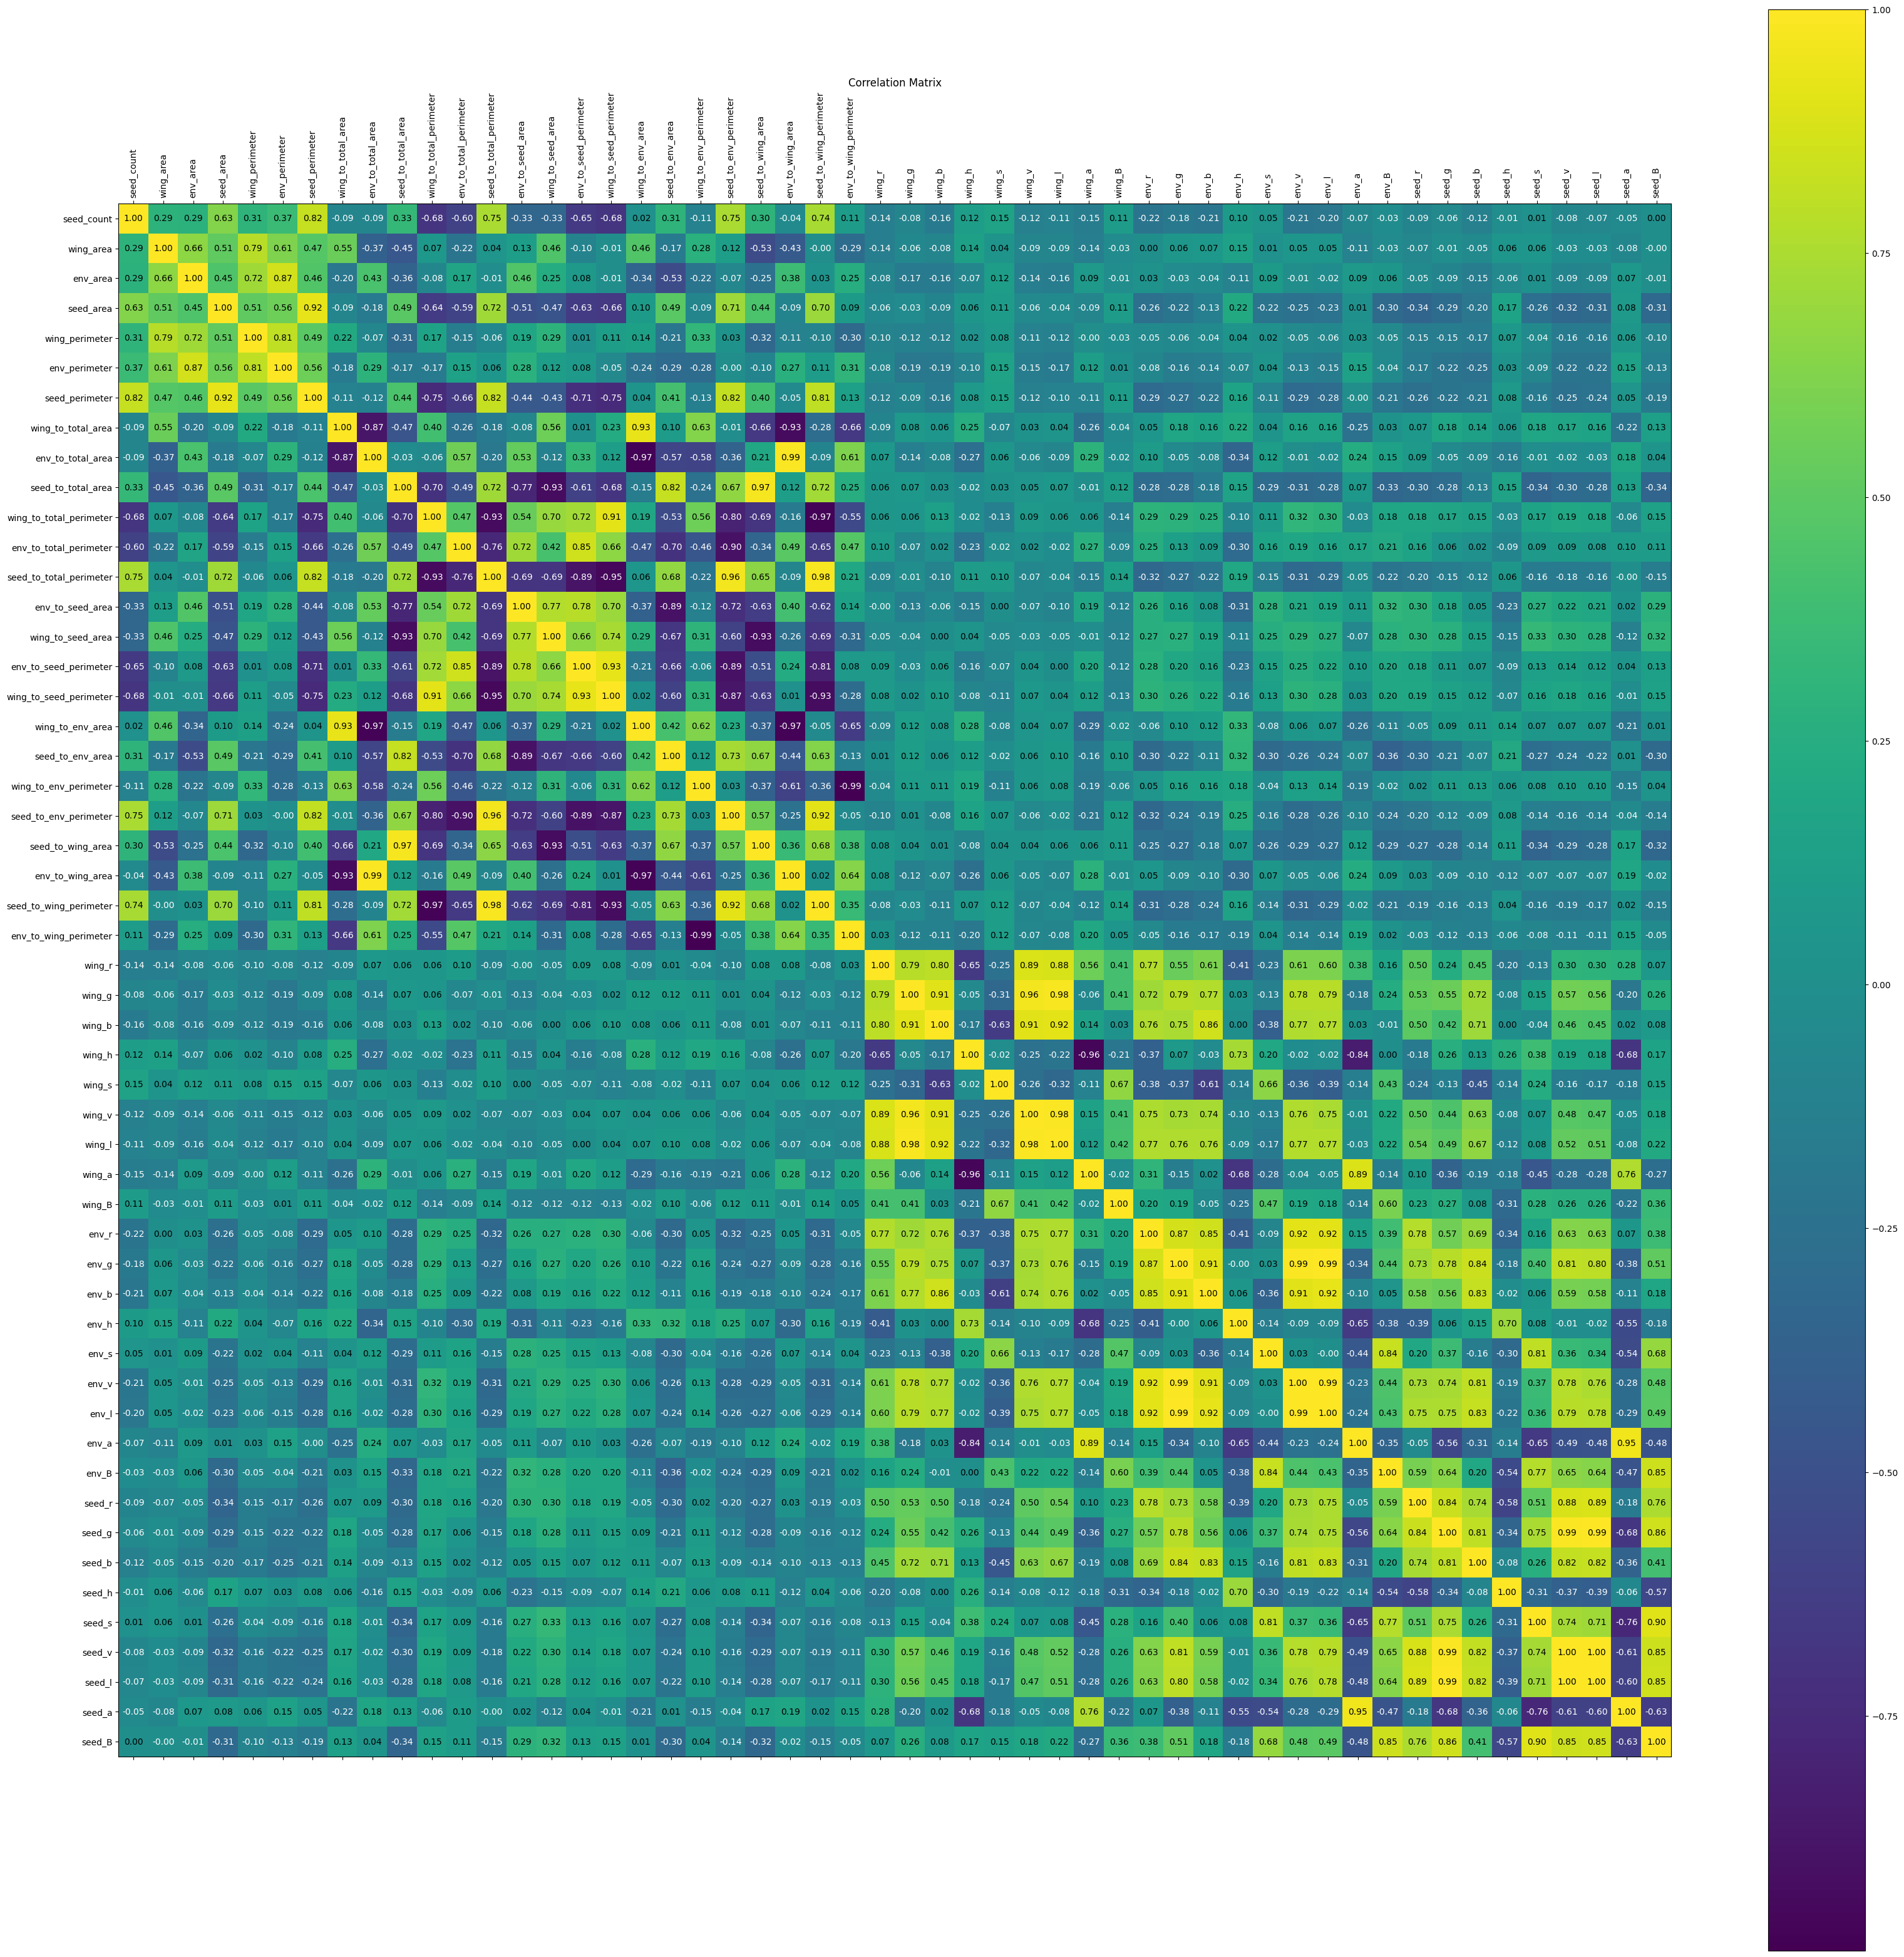

In [118]:
# make correlation matrix and plot as a heatmap
corrmatrix = measurements.iloc[:, 1:].corr()

plt.figure(figsize=(40, 40))
plt.matshow(corrmatrix, fignum=1)
plt.xticks(range(corrmatrix.shape[1]), corrmatrix.columns, fontsize=10, rotation=90)
plt.yticks(range(corrmatrix.shape[1]), corrmatrix.columns, fontsize=10)
plt.colorbar()
plt.title("Correlation Matrix")

# add correlation values to heatmap
for (i, j), val in np.ndenumerate(corrmatrix):
    # change text color to white if correlation is negative
    if val < 0:
        plt.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=10, color='white')
    else:
        plt.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=10)
plt.show()